In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#!find /content/drive/MyDrive -name 'CS4243'
#!find /content/drive/MyDrive -name 'output-train-by-char.zip'
#!find /content/drive/MyDrive -name 'output-test.zip'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/HL/output-train-by-char.zip'
extract_path = './dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    #print(zip_ref.namelist())
    zip_ref.extractall(extract_path)


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Inception v3 default input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

dataset = datasets.ImageFolder(root='./dataset/output-train-by-char', transform=transform)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15, 'g': 16, 'h': 17, 'i': 18, 'j': 19, 'k': 20, 'l': 21, 'm': 22, 'n': 23, 'o': 24, 'p': 25, 'q': 26, 'r': 27, 's': 28, 't': 29, 'u': 30, 'v': 31, 'w': 32, 'x': 33, 'y': 34, 'z': 35}


In [ ]:
# --- Model setup ---
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("CUDA Avail:", torch.cuda.is_available())

NUM_FINETUNE_CLASSES = 36 #a-z,0-9
model = timm.create_model('inception_v3', pretrained=True, num_classes=NUM_FINETUNE_CLASSES)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


CUDA Avail: True


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/95.5M [00:00<?, ?B/s]

In [ ]:
# --- Training ---
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(train_accuracy)

    # Validation phase
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy*100:.2f}%, "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy*100:.2f}%")



Epoch 1/10, Train Loss: 0.8464, Train Acc: 75.47%, Val Loss: 0.4321, Val Acc: 86.44%
Epoch 2/10, Train Loss: 0.3360, Train Acc: 89.00%, Val Loss: 0.3678, Val Acc: 88.28%
Epoch 3/10, Train Loss: 0.2458, Train Acc: 91.51%, Val Loss: 0.3529, Val Acc: 89.23%
Epoch 4/10, Train Loss: 0.1972, Train Acc: 92.89%, Val Loss: 0.3259, Val Acc: 89.59%
Epoch 5/10, Train Loss: 0.1687, Train Acc: 93.80%, Val Loss: 0.3843, Val Acc: 88.81%
Epoch 6/10, Train Loss: 0.1469, Train Acc: 94.56%, Val Loss: 0.3436, Val Acc: 90.46%
Epoch 7/10, Train Loss: 0.1235, Train Acc: 95.35%, Val Loss: 0.3454, Val Acc: 89.99%
Epoch 8/10, Train Loss: 0.1242, Train Acc: 95.52%, Val Loss: 0.3165, Val Acc: 90.73%
Epoch 9/10, Train Loss: 0.0996, Train Acc: 96.40%, Val Loss: 0.3437, Val Acc: 90.70%
Epoch 10/10, Train Loss: 0.0964, Train Acc: 96.53%, Val Loss: 0.3225, Val Acc: 90.99%


In [ ]:
torch.save(model.state_dict(), 'model2.pth')
from google.colab import files
files.download('model2.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

NameError: name 'json' is not defined

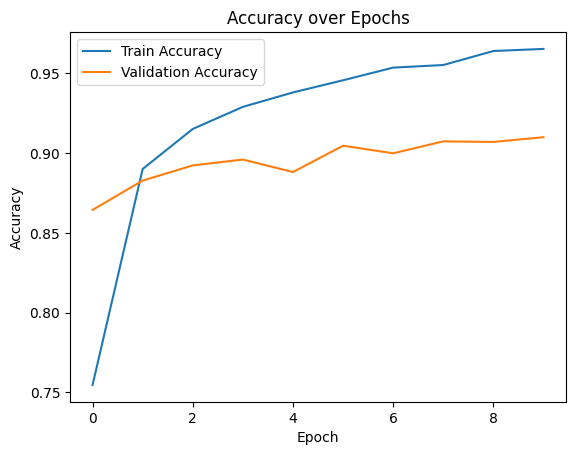

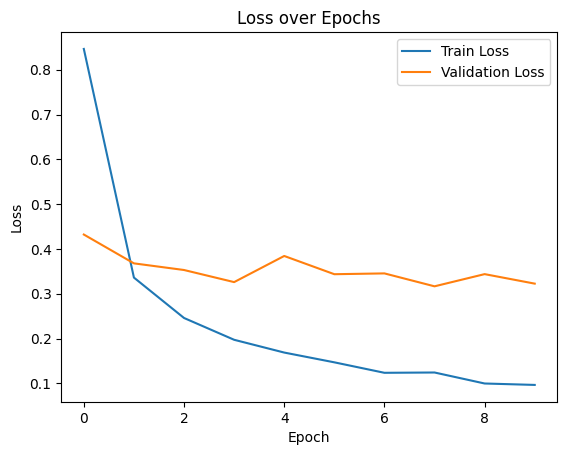

<Figure size 640x480 with 0 Axes>

In [ ]:
# --- Plot learning curves ---
import matplotlib.pyplot as plt

plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.show()
plt.savefig("I3_accuracy_curve.png")


plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.show()
plt.savefig("I3_loss_curve.png")

TEST

In [ ]:
zip_path = '/content/drive/MyDrive/HL/output-test.zip'
extract_path = './dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

test_dataset = datasets.ImageFolder(root='./dataset/output-test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32)


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score

model.eval()
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# Overall metrics
accuracy = accuracy_score(all_test_labels, all_test_preds)
precision = precision_score(all_test_labels, all_test_preds, average='macro', zero_division=0)
recall = recall_score(all_test_labels, all_test_preds, average='macro', zero_division=0)

print(f"\nTest Accuracy: {accuracy*100:.2f}%")
print(f"Test Macro Precision: {precision:.4f}")
print(f"Test Macro Recall: {recall:.4f}")

# Per-class metrics
class_names = list(test_dataset.class_to_idx.keys())
report = classification_report(all_test_labels, all_test_preds, target_names=class_names, zero_division=0)
print("\nDetailed Test Classification Report:")
print(report)

# Save report
with open("test_classification_report.txt", "w") as f:
    f.write(report)

files.download('test_classification_report.txt')



Test Accuracy: 88.74%
Test Macro Precision: 0.8953
Test Macro Recall: 0.8896

Detailed Test Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.81      0.63       258
           1       0.72      0.75      0.74       234
           2       0.89      0.92      0.90       249
           3       0.96      0.96      0.96       227
           4       0.97      0.89      0.93       235
           5       0.92      0.87      0.89       238
           6       0.92      0.96      0.94       224
           7       0.97      0.92      0.94       233
           8       0.93      0.95      0.94       253
           9       0.94      0.82      0.87       268
           a       0.98      0.88      0.93       268
           b       0.92      0.95      0.94       255
           c       0.93      0.91      0.92       256
           d       0.96      0.90      0.93       270
           e       0.93      0.95      0.94       237
           f       

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CITATION:

@article{DBLP:journals/corr/SzegedyVISW15,
  author    = {Christian Szegedy and
               Vincent Vanhoucke and
               Sergey Ioffe and
               Jonathon Shlens and
               Zbigniew Wojna},
  title     = {Rethinking the Inception Architecture for Computer Vision},
  journal   = {CoRR},
  volume    = {abs/1512.00567},
  year      = {2015},
  url       = {http://arxiv.org/abs/1512.00567},
  archivePrefix = {arXiv},
  eprint    = {1512.00567},
  timestamp = {Mon, 13 Aug 2018 16:49:07 +0200},
  biburl    = {https://dblp.org/rec/journals/corr/SzegedyVISW15.bib},
  bibsource = {dblp computer science bibliography, https://dblp.org}
}

LINK: https://huggingface.co/docs/timm/en/models/inception-v3

EMNIST (Extended MNIST) — for handwritten letters (balanced or letters split)
https://www.nist.gov/itl/products-and-services/emnist-dataset

https://github.com/ruchitapaithankar15/Optical-character-recognition-using-Inception-V3-and-VGG16


In [ ]:

model = timm.create_model('inception_v3', pretrained=True)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last two inception blocks
for name, child in model.named_children():
    if name in ['Mixed_7b', 'Mixed_7c']:
        for param in child.parameters():
            param.requires_grad = True

# Add classification head
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 36)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(train_accuracy)

    # Validation phase
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct_val / total_val
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy*100:.2f}%, "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy*100:.2f}%")

Epoch 1/10, Train Loss: 1.6476, Train Acc: 52.87%, Val Loss: 0.7809, Val Acc: 76.08%
Epoch 2/10, Train Loss: 0.6804, Train Acc: 79.03%, Val Loss: 0.6054, Val Acc: 81.23%
Epoch 3/10, Train Loss: 0.4555, Train Acc: 85.49%, Val Loss: 0.5391, Val Acc: 82.74%
Epoch 4/10, Train Loss: 0.3233, Train Acc: 89.44%, Val Loss: 0.5426, Val Acc: 83.48%
Epoch 5/10, Train Loss: 0.2330, Train Acc: 92.19%, Val Loss: 0.5706, Val Acc: 83.14%
Epoch 6/10, Train Loss: 0.1845, Train Acc: 93.82%, Val Loss: 0.5775, Val Acc: 83.72%
Epoch 7/10, Train Loss: 0.1474, Train Acc: 94.87%, Val Loss: 0.5996, Val Acc: 83.91%
Epoch 8/10, Train Loss: 0.1233, Train Acc: 95.84%, Val Loss: 0.6515, Val Acc: 83.91%
Epoch 9/10, Train Loss: 0.1090, Train Acc: 96.30%, Val Loss: 0.6593, Val Acc: 83.53%
Epoch 10/10, Train Loss: 0.0940, Train Acc: 96.95%, Val Loss: 0.6704, Val Acc: 84.16%


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

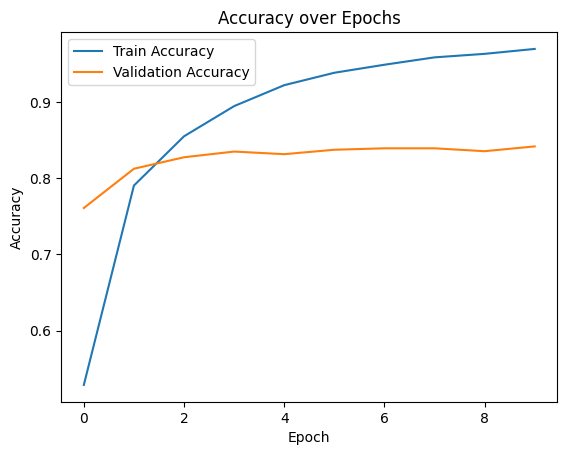

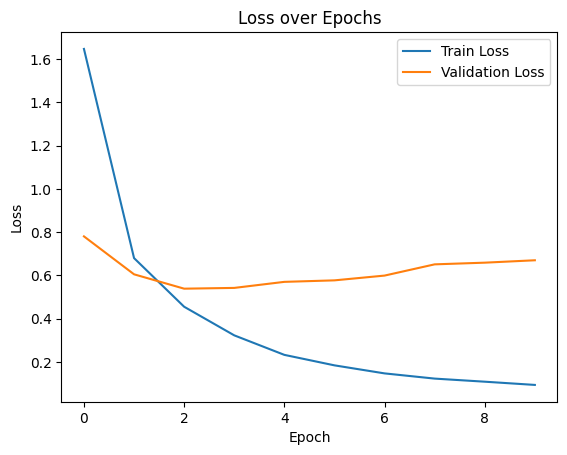

<Figure size 640x480 with 0 Axes>

In [ ]:
torch.save(model.state_dict(), 'model3.pth')
from google.colab import files
files.download('model3.pth')

# --- Plot learning curves ---
import matplotlib.pyplot as plt

plt.plot(train_acc_list, label='Train Accuracy')
plt.plot(val_acc_list, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()
plt.show()
plt.savefig("I3_accuracy_curve.png")


plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.show()
plt.savefig("I3_loss_curve.png")

TEST

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score

model.eval()
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_test_preds.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# Overall metrics
accuracy = accuracy_score(all_test_labels, all_test_preds)
precision = precision_score(all_test_labels, all_test_preds, average='macro', zero_division=0)
recall = recall_score(all_test_labels, all_test_preds, average='macro', zero_division=0)

print(f"\nTest Accuracy: {accuracy*100:.2f}%")
print(f"Test Macro Precision: {precision:.4f}")
print(f"Test Macro Recall: {recall:.4f}")

# Per-class metrics
class_names = list(test_dataset.class_to_idx.keys())
report = classification_report(all_test_labels, all_test_preds, target_names=class_names, zero_division=0)
print("\nDetailed Test Classification Report:")
print(report)

# Save report
with open("test_classification_report.txt", "w") as f:
    f.write(report)

files.download('test_classification_report.txt')


Test Accuracy: 81.69%
Test Macro Precision: 0.8230
Test Macro Recall: 0.8199

Detailed Test Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.69      0.59       258
           1       0.55      0.66      0.60       234
           2       0.87      0.88      0.87       249
           3       0.91      0.90      0.90       227
           4       0.87      0.88      0.88       235
           5       0.86      0.82      0.84       238
           6       0.92      0.90      0.91       224
           7       0.76      0.93      0.84       233
           8       0.92      0.82      0.87       253
           9       0.89      0.75      0.81       268
           a       0.88      0.76      0.81       268
           b       0.85      0.87      0.86       255
           c       0.91      0.85      0.88       256
           d       0.93      0.85      0.89       270
           e       0.91      0.90      0.91       237
           f       

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>